In [67]:
import numpy as np
import gzip
import scipy.stats

feedback


Good. You generally don't need to make an explicit call to `broadcast_to` since
the broadcasting will happen automatically when you apply an operation to arrays
of different shape.

In your testing, what you want is `(x == y).all()` rather than
`x.all() == y.all()`. For a numeric array `x.all()` will just be `True` unless
any elements are zero, so two different numeric arrays will often compare equal
even if they aren't.

# K-Nearest Neighbors vs Linear Classifier

In this homework we'll explore two different methods of classifing the MNIST database we looked at during our lab. The first is a simple but effective _non-parametric_ classification algorithm called $k$-nearest neighbors (KNN). This one will serve mostly as a way to practice some of the array programming concepts we've seen. The second is an extension of the work we did in lab from the binary classification setting to multiclass classification.

## Array Programming

The first part of this assignment asks you to solve some array programming problems. These are meant to help you develop a feel for array programming and to get some practice thinking in terms of broadcasting. They are also more specifically designed as leading questions to help you figure out the code that occurs later in the notebook when we're implementing KNN and linear models.

Fill in the body of each of the functions below. For all of these functions, you should avoid using explicit loops and rely on broadcasting semantics. I'd also recommend running a few tests to make sure everything is working.

When you're working with broadcasting and array programming, it's often helpful to think about the _shapes_ of the arrays you have access to and the arrays you want to produce. In the first couple of exercises I'll include some notes about how I would use this kind of thinking to approach the problem.

In [68]:
def outer_product(x, y, f=np.multiply):
    """
    Compute the outer product of two vectors: x (of shape (N,)) and y (of shape
    (M,)). The outer product x y^T is a matrix A of shape (N, M) where for any
    i and j, A[i,j] = x[i] * y[j]
    """
    # If we're thinking about shapes, we need to create an array of shape (N,M)
    # by broadcasting arrays of shape (N,) and (M,). Remembering our
    # broadcasting rules, if our first array had shape (N, 1) instead of (N,)
    # then this would work out for us.
    # Note that we can use the outer product pattern to apply _any_ operation
    # between all pairs of elements from two arrays by replacing the multiplication
    # with some other operation. This will be relevant in the KNN section below.
    # The outer product also appears as part of the gradient computation in the
    # linear models section, but in a slightly different form.

    N = x.shape[0]
    M = y.shape[0]
    
    # Reshape x so that is is a column, then expand so that there are M columns. Then f should broadcast to y
    x = (np.broadcast_to(np.reshape(x, (N,1)), (N,M) ))
    return f(x, y)

def norm_squared(x):
    """
    Given a matrix x of shape (N, M) compute the squared Euclidean norm of each
    row of the matrix. The squared Euclidean norm for a vector v is defined as
    v_1^2 + v_2^2 + ... + v_M^2. That is, it is the sum of the squares of each
    element of the vector.
    """
    # In terms of shapes, we're taking in an array of shape (N, M) and
    # producing a single number for each row, so the output will have shape
    # (N,). Accordingly, we'll need some kind of aggregation along axis 1 to
    # "squash" the columns of the array together.

    # The squared norm will come up again in the KNN section.
    # The same pattern, but with different computations, will appear when we
    # compute the softmax function in the linear model section.

    # Square entries and sum along last axis
    return np.sum(np.square(x), axis=-1)


def row_multiply(m, x):
    """
    Given a matrix m of shape (N, M) and a vector x of shape (N,), multiply
    each row of m by the corresponding element of x.
    """

    # This pattern will appear as part of the softmax funciton in the linear

    N = x.shape[0]
    M = m.shape[1]

    # Reshape x then make it into an NxM matrix, then broadcast multiplication to each row
    return np.broadcast_to(np.reshape(x, (N,1)), (N,M)) * m



### Testing Functions
To get the intuitive sense of equality between arrays (that `x[i,j] == y[i,j]` for all entries), use `x.all() == y.all()`.

In [69]:
# We can test outer_product() against np.outer()
assert outer_product(np.array([1, 2, 4]), np.array([4, 5])).all() == np.outer(np.array([1, 2, 4]), np.array([4, 5])).all()
assert outer_product(np.array([0,1,2]), np.array([10,20,30])).all() == np.outer(np.array([0,1,2]), np.array([10,20,30])).all()

assert norm_squared(np.array([[1, 2, 3], [4, 5, 6]])).all() == np.array([14, 77]).all()
assert norm_squared(np.array([1,2,3])).all() == np.array([16]).all()

assert row_multiply(np.array([[1, 2, 3], [4, 5, 6]]), np.array([2, 4])).all() == np.array([[2, 4, 6], [16, 20, 24]]).all()
assert row_multiply(np.array([[5], [6], [7]]), np.array([1, 2, 3])).all() == np.array([[5], [12], [21]]).all()


## Preparing Data

The first part of this notebook is the same as our lab: we just need to get the MNIST data into Python. This code is already complete, but you may need to modify the file names at the bottom of this cell to work with your system.

In [70]:
# Code to extract the MNIST data is adapted from https://gist.github.com/awjuliani/1d21151bc17362bf6738c3dc02f37906

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]

def extract_images(filename):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError(
              'Invalid magic number %d in MNIST image file: %s' %
              (magic, filename))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols)
    return data

def extract_labels(filename):
    """Extract the labels into a 1D uint8 numpy array [index]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError(
              'Invalid magic number %d in MNIST label file: %s' %
              (magic, filename))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
    return labels

images = extract_images("/Users/aghassaei/Documents/academics/2023/csci378/labs/linear_lab/train-images-idx3-ubyte.gz")
labels = extract_labels("/Users/aghassaei/Documents/academics/2023/csci378/labs/linear_lab/train-labels-idx1-ubyte.gz")

Extracting /Users/aghassaei/Documents/academics/2023/csci378/labs/linear_lab/train-images-idx3-ubyte.gz
Extracting /Users/aghassaei/Documents/academics/2023/csci378/labs/linear_lab/train-labels-idx1-ubyte.gz


One thing we haven't talked about so far in class is how we measure a model's performance after we're done training. Using the same data to evaluate the model that we used to train it introduces a lot of bias, so it's typical to reserve, or "hold out", some portion of the data for measuring how well the model actually works after training. For today we'll follow typical practice and hold out 20% of the data. We call this the _validation set_. The other 80% is called the _training set_.

In [71]:
# Shuffle the data
perm = np.random.permutation(images.shape[0])
images = images[perm]
labels = labels[perm]

# Split it
train_size = int(images.shape[0] * 0.8)
train_images = images[:train_size].reshape(-1, 28 * 28)
train_labels = labels[:train_size]
valid_images = images[train_size:].reshape(-1, 28 * 28)
valid_labels = labels[train_size:]

You should only use `train_images` and `train_labels` for training your model. You can use `valid_images` and `valid_labels` for testing how well a model works.

## K-Nearest Neighbors

In a $k$-nearest neighbors classifier, we predict which class a point will belong to by first computing it's distance from each point in the training set. Then we choose the $k$ points which are closest to the point under consideration and take a majority vote of the labels of those points. Whichever label has the most votes is our prediction. Here's a visualization, modeled after the one found on the Wikipedia page (you don't need to fill in anything in this cell).

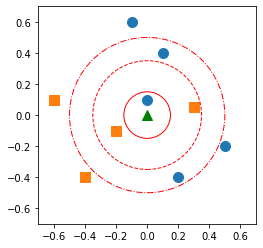

In [72]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineRenderer.figure_format = 'retina'
mpl.rcParams['lines.markersize'] = 10

xs = np.array([[0, 0.1], [0.3, 0.05], [-0.2, -0.1], [-0.1, 0.6], [0.2, -0.4], [-0.6, 0.1], [0.5, -0.2], [-0.4, -0.4], [0.1, 0.4]])
ys = np.array([0, 1, 1, 0, 0, 1, 0, 1, 0])

fig, ax = plt.subplots()
plt.scatter(xs[ys == 0, 0], xs[ys == 0, 1], marker='o')
plt.scatter(xs[ys == 1, 0], xs[ys == 1, 1], marker='s')
plt.plot(0, 0, marker='^', color='g')
circle1 = plt.Circle((0, 0), 0.15, color='r', fill=False)
circle3 = plt.Circle((0, 0), 0.35, color='r', fill=False, linestyle='--')
circle5 = plt.Circle((0, 0), 0.5, color='r', fill=False, linestyle='-.')
ax.add_patch(circle1)
ax.add_patch(circle3)
ax.add_patch(circle5)
ax.set_xlim([-0.7, 0.7])
ax.set_ylim([-0.7, 0.7])
ax.set_aspect('equal')
plt.show()

In the figure above, the green triangle represents a new point we are trying to classify while the orange squares and blue circles represent our dataset. The three red circles help to visualize the $k$-nearest neighbors classification for different values of $k$. The innermost (solid) circle corresponds to $k = 1$. Since the nearest point is a blue circle, we would classify the triangle as a blue circle. The middle (dashed) circle represents $k = 3$. In this case there are two orange squares and one blue circle, so by majority vote we would classify the triangle as an orange square. The outermost (dash-dotted) circle represents $k = 5$. In this case, there are tree blue circles and two orange squares, so we classify the triangle as a circle.

Note that there may sometimes be ties. In general, there are many ways to break ties--for this notebook, the code chooses arbitrarily between each of the classes involved in the tie.

Now we're ready to implement the KNN classifier. The function `knn` below expects an array `train_data` of shape `(N, D)` where `N` is the number of training data points and `D` is the dimension of each point (784 for the MNIST data), an array `train_outputs` of shape `(N,)` containing the labels for each point, and an array `eval_data` of shape `(M, D)` where `M` is the number of points to eavluate on. You'll need to fill in the code to compute the (standard Euclidean) distance between each point in `eval_data` and every point in `train_data`. These distances should be stored in the `distances` variable. The given code assumes that `distances` is an array of shape `(M, N)`. The code that's already present in the next cell takes care of sorting these distances, taking the first `k` elements, and performing the actual voting. Try to compute the distances using _only_ broadcast semantics without any (explicit) loops. For partial credit, you can loop over `eval_data` and consider each row one at a time, but still try to use broadcasting to simultaneously compute the distance from that point to each point in `train_data`. For less credit, you can loop over both `eval_data` and `train_data`.

NOTE: since all we need is an _ordering_ on the distances, and not the actual values of the distances, it is sufficient to compute the squared distance. This avoids a square root operation and saves some time.

In [73]:
def knn(train_data, train_outputs, eval_data, k=5):
    N = train_data.shape[0] # rows of training data
    M = eval_data.shape[0] # rows of eval data
    D = eval_data.shape[1] # dimensions (cols of both training and eval data)
    train_data_3d = train_data[:,np.newaxis] # add third dimension to training data
    train_data_3d_populated = np.broadcast_to(train_data_3d, (N,M,D)) # broadcast to third dimension
    relative_distances = train_data_3d_populated - eval_data # get the distances from points in eval data and training data
    distances = norm_squared(relative_distances).transpose() # compute the norm squared and transpose data
    inds = np.argpartition(distances, k, axis=1)[:,:k]
    votes = train_outputs[inds]
    prediction = scipy.stats.mode(votes, axis=1).mode
    return prediction

Now we can test out your `knn` function. The code below picks `train_size` elements of the training set and `test_size` elements of the validation set and calls your `knn` function on these two samples. It then computes the accuracy of the KNN classifier by checking how often the predicted label agrees with the actual label on the validaiton set. The `knn` function can be quite slow if you try to evaluate on the entire training and validation sets, which is why we're only using a subset here. I found that 10000 training points gives pretty good results (in the 92-95% range) and a `test_size` of 200 can run within a few seconds on my machine. You may need to change these numbers depending on your computer and how your `knn` function is written. There's no code to implement in this cell.

In [74]:
train_size = 10000
test_size = 200
preds = knn(train_images[:train_size].astype(np.float32),
            train_labels[:train_size],
            valid_images[:test_size].astype(np.float32),
            k=10)
print("Accuracy:", np.mean(preds == valid_labels[:test_size]))

Accuracy: 0.92


We can also plot a few of the images along with the KNN predictions. There is no code to implement in this cell.

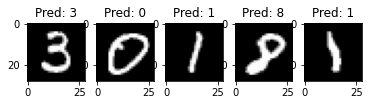

In [75]:
fig, axs = plt.subplots(1, 5)
idxs = np.random.randint(0, valid_images.shape[0], size=5)
preds = knn(train_images.astype(np.float32), train_labels, valid_images[idxs].astype(np.float32), k=10)
for i in range(5):
    axs[i].imshow(valid_images[idxs[i]].reshape(28, 28), cmap='gray', vmin=0, vmax=255)
    axs[i].title.set_text("Pred: " + str(preds[i]))
plt.show()

## Linear Model

Now let's switch gears and go back to the linear models we were working with in class. We'll extend our binary classifier to a multiclass classifier that can choose between all 10 possible digits. In the binary setting, because we only had two classes, we could use a single number output to represent a probability distribution over the two possibilities. Now we need to represent a distribution over 10 classes. Therefore, we'll need to have a model that outputs 10 numbers rather than one. That is, we need a model $g : \mathbb{R}^D \to \mathbb{R}^{10}$ (where $D$ is the number of dimensions in each input data point) and we need a way to transform arbitrary vectors of 10 values into probability distributions. For the model, we simply extend our dot product to a matrix multiplication. For numerical reasons, we often think of the input $x$ as a row vector, so the linear part of our model is $g(W; x) = x W$ where $W \in \mathbb{R}^{D \times 10}$ is a matrix of parameters which we'll train. In order to transform the output to a distribution, we use the _softmax_ function. For a vector $z \in \mathbb{R}^C$, the softmax function is defined as

$$
S(z)_i = \frac{e^{z_i}}{\sum_{j=1}^C e^{z_j}}
$$

where the subscript $i$ is an index into a vector and $i$ and $j$ each range over the number of classes (in this case 10). Our full model is then $f(W; x) = S(x W)$. Note that a lot of authors represent the softmax by $\sigma$ so you may see that in external resource. I chose to use $S$ since we already used $\sigma$ for the logistic sigmoid.

For our loss function, we can continue to use cross-entropy, but we'll now need to consider that there are more than two classes. The cross-entropy can be derived in the same way, and we end up with the expression

$$
\ell(x, y, W) = -\log f(W; x)_y
$$

That is, it's the negative log of the predicted probability for the _correct_ class, indicated by $y$. The gradient of $\ell$ is given by

$$
\nabla_W \ell(x, y, W) = x (f(W; x) - h(y))^T
$$

where $h(y)$ is a _one-hot_ encoding of $y$. Remember that the output $y$ is an integer between 0 and 9. $h(y)$ is a vector where each element is zero except for the element at index $y$, which is one. For example

```
h(3) = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
h(0) = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
h(8) = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
```

The expression $x (f(W; x) - h(y))^T$ is the _outer product_ of two vectors $x$ and $f(W; x) - h(y)$. As we saw above, it is the matrix product we get when we treat $x$ as a $D \times 1$ matrix and treat $f(W; x) - h(y)$ as a $1 \times 10$ vector. That is, it is a matrix where the entry at index $i,j$ is the product $x_i (f(W; x) - h(y))_j$.

I've put a derivation of the gradient at the end of the document.

Remember that the overall loss is

$$
L(W) = \sum_{(x,y) \in \mathcal{D}} \ell(x, y, W)
$$

and then the gradient is given by

$$
\nabla L(W) = \sum_{(x,y) \in \mathcal{D}} \nabla_W \ell(x, y, W)
$$

Your task now is to train a linear model using gradient descent. Parts of the training code are filled in for you. You need to implement two things:

- The computation of the predicted probability distribution. That is, given $W$ (as `weights`) and the input data (as `train_data`), you need to compute a matrix of size $N \times 10$ where $N$ is the number of data points and each row is a distribution over the possible classes. You'll also need to produce `valid_preds`, but this uses exactly the same code as `preds` except that the input is `valid_data` instead of `train_data`.
- The gradient computation. That is, you need to produce the $D \times 10$ matrix `weight_grad` based on the formula for the gradient above.

In [76]:
def train(train_data, train_outputs, valid_data, valid_outputs, epochs=100, learning_rate=1e-5):
    weights = np.zeros((train_data.shape[1], 10))
    one_hot = np.zeros((train_outputs.shape[0], 10))
    one_hot[np.arange(train_outputs.shape[0]), train_outputs] = 1
    # Each row of one_hot represents h(y) for one of the elements y of train_outputs
    for i in range(epochs):
        z = train_data @ weights
        softmax_z = np.exp(z) / np.sum(np.exp(z), axis =1)[:, np.newaxis] #or use softmax build in (can also do .expanddims(axis=1)        
        preds = softmax_z
        correct_pred = preds[np.arange(preds.shape[0]), train_outputs]
        # correct_pred is the the probability assigned to the correct class by our model
        loss = np.mean(-np.log(correct_pred))
        if i % 10 == 0:
            z2 = valid_data @ weights
            valid_preds =   np.exp(z2) / np.sum(np.exp(z2), axis =1)[:, np.newaxis]                #valid preds is same but with valid_data instead of train_data
            valid_max = np.argmax(valid_preds, axis=1)
            accuracy = np.mean(valid_max == valid_outputs)
            print("Epoch:", i, " -- Loss:", loss, " -- validation accuracy:", accuracy)
        weight_grad = train_data.transpose() @ (preds - one_hot)
        weights -= learning_rate * weight_grad
    return weights

Now we can try out your training code. First, we'll normalize the input data like we did in the lab. Remember that for image data, we typically compute the mean over _all_ of the pixels for each color channel (and in this case we only have one color channel).

In [77]:
mean = np.mean(train_images)
std = np.std(train_images)

norm_train_images = (train_images - mean) / std
norm_valid_images = (valid_images - mean) / std

In [78]:
model_weights = train(norm_train_images,
                      train_labels,
                      norm_valid_images,
                      valid_labels,
                      epochs=500,
                      learning_rate=1e-5)

Epoch: 0  -- Loss: 2.3025850929940455  -- validation accuracy: 0.10091666666666667
Epoch: 10  -- Loss: 1.6778966612460227  -- validation accuracy: 0.75275
Epoch: 20  -- Loss: 1.325881876600691  -- validation accuracy: 0.8040833333333334
Epoch: 30  -- Loss: 0.770818253291568  -- validation accuracy: 0.8381666666666666
Epoch: 40  -- Loss: 0.40492155496884863  -- validation accuracy: 0.8999166666666667
Epoch: 50  -- Loss: 0.35723841018516866  -- validation accuracy: 0.9048333333333334
Epoch: 60  -- Loss: 0.9662861802796591  -- validation accuracy: 0.7983333333333333
Epoch: 70  -- Loss: 0.9659617844172839  -- validation accuracy: 0.8225
Epoch: 80  -- Loss: 0.38392853350741235  -- validation accuracy: 0.9070833333333334
Epoch: 90  -- Loss: 0.3471040754096248  -- validation accuracy: 0.91075
Epoch: 100  -- Loss: 0.5103232714991381  -- validation accuracy: 0.8730833333333333
Epoch: 110  -- Loss: 0.45176429252756845  -- validation accuracy: 0.8766666666666667
Epoch: 120  -- Loss: 0.48521488380

If things are going well you should see your loss going down over time and your validation accuracy going up. If your loss is diverging, try lowering your learning rate. If it looks like training hasn't finished, try running for more epochs or increasing the learning rate. With a little bit of tuning I'm hitting around 92% accuracy on the validation set.

Finally, we can visualize some predictions. The code below shows the predicted class for each image long with the predicted probability for that class. You'll need to fill in the part that computes predictions for each of the selected images so that the variable `preds` contains a probability distribution over the 10 classes. This is the same as the code you wrote above in the `train` function to produce `preds` except that the input data is now called `viz_images`.

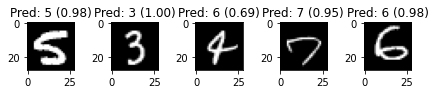

In [80]:
fig, axs = plt.subplots(1, 5)
fig.tight_layout()
idxs = np.random.randint(0, valid_images.shape[0], size=5)
viz_images = norm_valid_images[idxs]
z = viz_images @ model_weights
softmax_z = np.exp(z) / np.sum(np.exp(z), axis =1)[:, np.newaxis] #or use softmax build in (can also do .expanddims(axis=1)        
preds = softmax_z
max_ind = np.argmax(preds, axis=1)
for i in range(5):
    axs[i].imshow(valid_images[idxs[i]].reshape(28, 28), cmap='gray', vmin=0, vmax=255)
    axs[i].title.set_text("Pred: {} ({:.2f})".format(max_ind[i], preds[i,max_ind[i]]))
plt.show()

## Appendix: Gradient

Here is the derivation of the gradient of our linear model presented up above. Remember our loss function:

$$
\ell(x, y, W) = -\log f(W; x)_y
$$

For convenience, I'll define some notation:

- $l = W x$ is a vector of logits
- $p = S(l) = S(W x)$ is the distribution output by the model.

We'll compute the gradient by stepping backward through the model and using the chain rule. That is, we'll start by computing the gradient of the loss w.r.t. $p$, then we'll get the loss w.r.t. $l$, then we'll move on to $W$.

$$
\frac{\partial \ell}{\partial p_i} = \begin{cases} 0 & i \neq y \\ -1 / p_i & i = y \end{cases}
$$

Then we need to compute the partial derivatives of each output of the softmax with respect to each input. We'll start by finding the derivative of each softmax output with respect to the _corresponding_ input.

$$
\begin{align}
\frac{\partial S(z)_i}{\partial z_i} &= \frac{\partial}{\partial z_i} \frac{e^{z_i}}{\sum_k e^{z_k}} \\
&= \frac{e^{z_i} \left (\sum_k e^{z_k} \right) - e^{2 z_i}}{\left( \sum_k e^{z_k} \right)^2} \\
&= \frac{e^{z_i}}{\sum_k e^{z_k}} \cdot \frac{\sum_k e^{z_k} - e^{z_i}}{\sum_k e^{z_k}} \\
&= S(z)_i (1 - S(z)_i)
\end{align}
$$

Now we consider the derivative of $S(z)_i$ w.r.t. $z_j$ when $i \neq j$.

$$
\begin{align}
\frac{\partial S(z)_i}{\partial z_j} &= \frac{\partial}{\partial z_j} \frac{e^{z_i}}{\sum_k e^{z_k}} \\
&= \frac{ - e^{z_i} e^{z_j}}{\left( \sum_k e^{z_k} \right)^2} \\
&= \frac{-e^{z_i}}{\sum_k e^{z_k}} \cdot \frac{e^{z_j}}{\sum_k e^{z_k}} \\
&= -S(z)_i S(z)_j
\end{align}
$$

Notice that $p_i = S(l)_i$. Now we have

$$
\begin{align}
\frac{\partial \ell}{\partial l_i} &= \sum_k \frac{\partial \ell}{\partial p_k} \frac{\partial p_k}{\partial l_i} \\
&= \begin{cases} -\frac{1}{p_y} p_i ( 1 - p_i ) & i = y \\ \frac{1}{p_y} p_i p_y & i \neq y \end{cases} \\
&= \begin{cases} - (1 - p_i) & i = y \\ p_i & i \neq y \end{cases} \\
&= p_i - \delta_{i,y}
\end{align}
$$

where $\delta_{i,y}$ is one if $i = y$ and zero otherwise. Finally,

$$
\nabla_W \ell(x, y, W) = \nabla_l \ell(x, y, W) \nabla_W l = x (p - h(y))^T
$$